# Automatic annotation of a single-cell RNA-seq dataset using CellTypist and Scanpy

## Loading Python modules and dataset

In [1]:
import scanpy as sc
import scrublet as scr
import celltypist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

We first load the dataset from HDF5 filtered barcode matrix from Cell Ranger. The data has been obtained from the 10x Genomics [website](https://www.10xgenomics.com/datasets/10-k-pbm-cs-from-a-healthy-donor-v-3-chemistry-3-standard-3-0-0)

In [2]:
file_path = "data/pbmc_10k.h5"
adata = sc.read_10x_h5(file_path)

In [3]:
adata

AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
adata.var_names_make_unique()

## Quality control

## Find doublets
First of all, we are going to use Scrublet to detect likely doublet:

In [5]:
# Convert sparse matrix to dense for Scrublet
scrub = scr.Scrublet(adata.X.toarray())

In [6]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 5.0%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.8%
Elapsed time: 11.4 seconds


In [7]:
adata.obs['doublet_scores'] = doublet_scores
adata.obs['predicted_doublets'] = predicted_doublets

In [8]:
doublet_scores

array([0.05263158, 0.07272727, 0.04068768, ..., 0.11836735, 0.04368359,
       0.00989315])

In [9]:
predicted_doublets

array([False, False, False, ..., False, False, False])

Let's visualize the distribution of the doublet scores:  

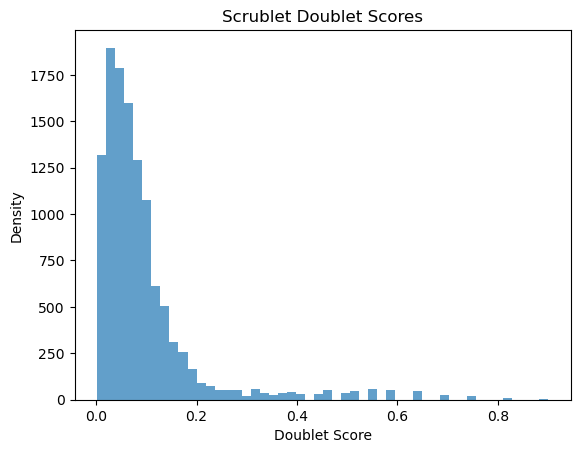

In [10]:
plt.hist(doublet_scores, bins = 50, alpha = 0.7)
plt.xlabel('Doublet Score')
plt.ylabel('Density')
plt.title('Scrublet Doublet Scores')
plt.show()

... storing 'feature_types' as categorical
... storing 'genome' as categorical


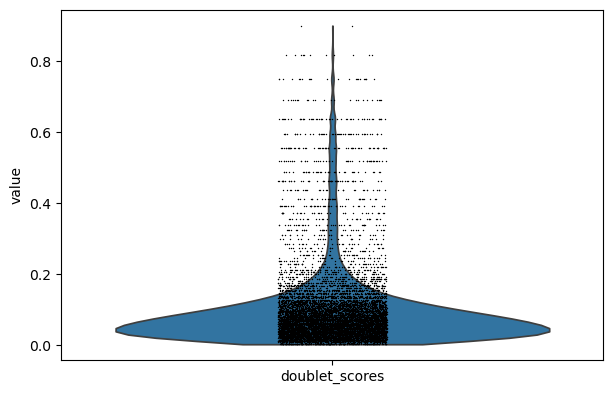

In [11]:
sc.pl.violin(adata, 'doublet_scores')

## Standard preprocessing

In [12]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [13]:
adata.var

,gene_ids,feature_types,genome,mt,ribo,hb
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,False,False
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,False,False
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,False,False
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,False,False
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,False,False
...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38,False,False,False
AC233755.1,ENSG00000275063,Gene Expression,GRCh38,False,False,False
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,False,False
AC213203.1,ENSG00000277475,Gene Expression,GRCh38,False,False,False


In [14]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

In [15]:
adata.obs

,doublet_scores,predicted_doublets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCCAAGCGCCCAT-1,0.052632,False,1087,6.992096,2204.0,7.698483,34.437387,44.782214,55.716878,73.366606,52.0,3.970292,2.359347
AAACCCAAGGTTCCGC-1,0.072727,False,4200,8.343078,20090.0,9.908028,30.751618,43.753111,55.739174,67.819811,1324.0,7.189168,6.590343
AAACCCACAGAGTTGG-1,0.040688,False,1836,7.515889,5884.0,8.680162,42.641061,52.923182,62.542488,75.254929,633.0,6.452049,10.757988
AAACCCACAGGTATGG-1,0.010830,False,2216,7.703910,5530.0,8.618124,32.839060,41.681736,51.175407,65.280289,434.0,6.075346,7.848101
AAACCCACATAGTCAC-1,0.029502,False,1615,7.387709,5106.0,8.538367,41.676459,56.423815,65.648257,78.162946,553.0,6.317165,10.830396
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTCATGT-1,0.135196,False,1331,7.194437,3937.0,8.278428,46.405893,55.956312,65.278131,78.892558,783.0,6.664409,19.888241
TTTGTTGGTTTGAACC-1,0.023124,False,1401,7.245655,4245.0,8.353733,43.910483,58.186101,67.255595,78.775029,375.0,5.929589,8.833922
TTTGTTGTCCAAGCCG-1,0.118367,False,1668,7.419980,5602.0,8.631058,45.430203,59.371653,67.832917,79.150303,524.0,6.263398,9.353803
TTTGTTGTCTTACTGT-1,0.043684,False,1745,7.465083,6757.0,8.818482,48.068670,63.830102,71.496226,81.352671,520.0,6.255750,7.695724


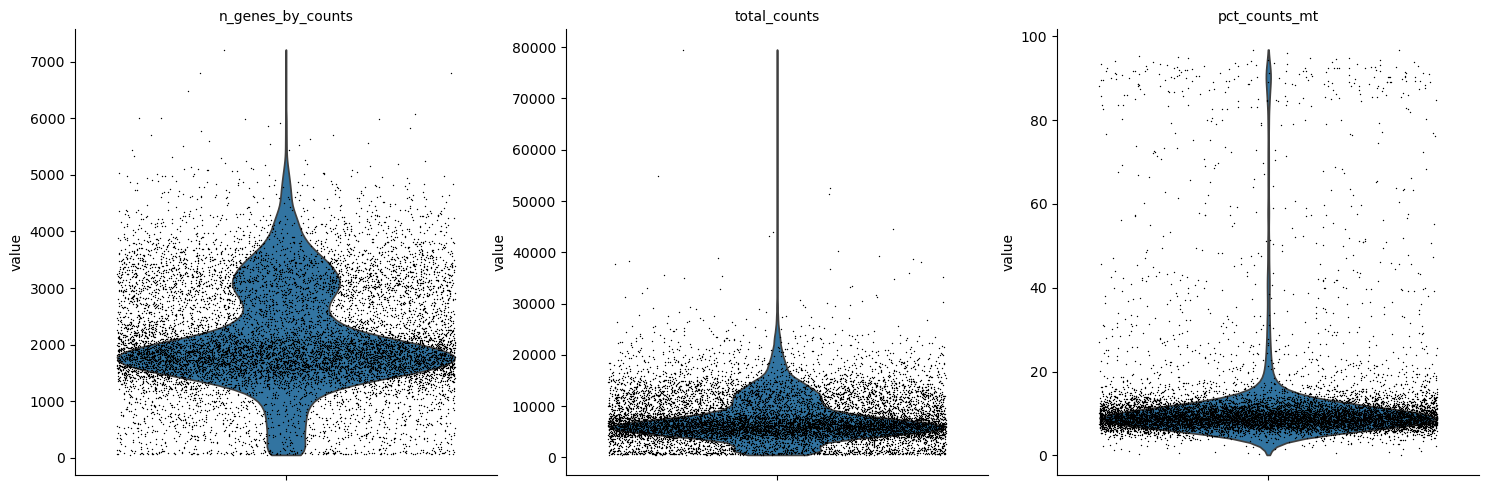

In [16]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True
)

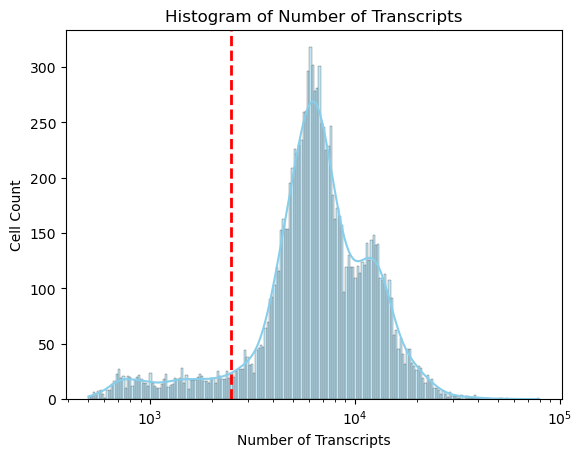

In [17]:
min_total_counts = 2500
total_counts_data = adata.obs['total_counts']
sns.histplot(total_counts_data, bins=200, kde=True, color='skyblue', edgecolor='black', log_scale=True)
plt.axvline(x=min_total_counts, color='red', linestyle='--', linewidth=2, label='Threshold = 2500')
plt.xlabel('Number of Transcripts')
plt.ylabel('Cell Count')
plt.title('Histogram of Number of Transcripts')
plt.show()

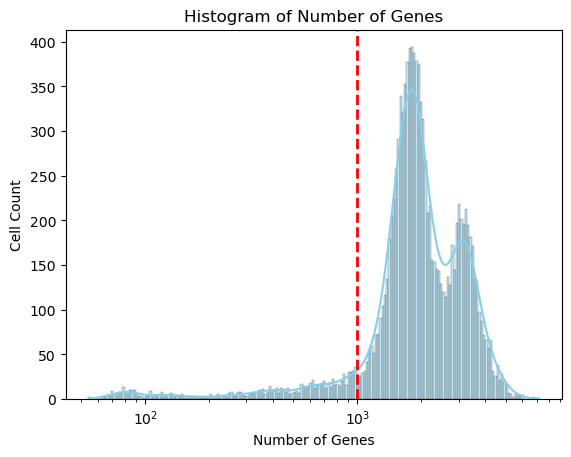

In [18]:
min_genes = 1000
total_genes_data = adata.obs['n_genes_by_counts']
sns.histplot(total_genes_data, bins=200, kde=True, color='skyblue', edgecolor='black', log_scale=True)
plt.axvline(x=min_genes, color='red', linestyle='--', linewidth=2, label='Threshold = 1000')
plt.xlabel('Number of Genes')
plt.ylabel('Cell Count')
plt.title('Histogram of Number of Genes')
plt.show()

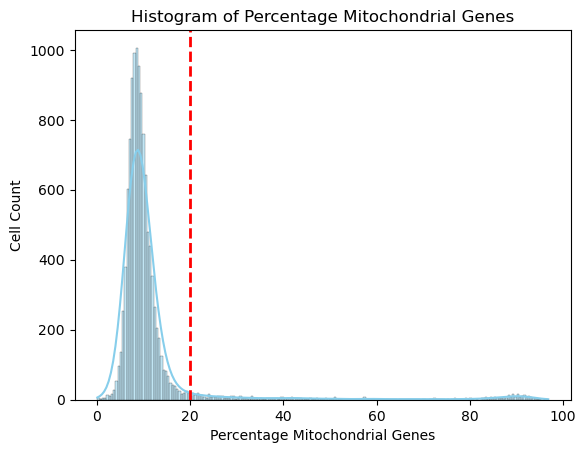

In [19]:
max_mito = 20
pct_counts_mt_data = adata.obs['pct_counts_mt']
sns.histplot(pct_counts_mt_data, bins=200, kde=True, color='skyblue', edgecolor='black', log_scale=False)
plt.axvline(x=max_mito, color='red', linestyle='--', linewidth=2, label='Threshold = 15')
plt.xlabel('Percentage Mitochondrial Genes')
plt.ylabel('Cell Count')
plt.title('Histogram of Percentage Mitochondrial Genes')
plt.show()

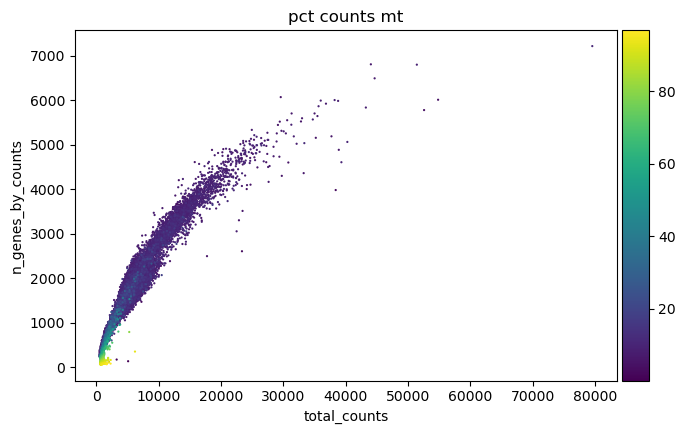

In [20]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

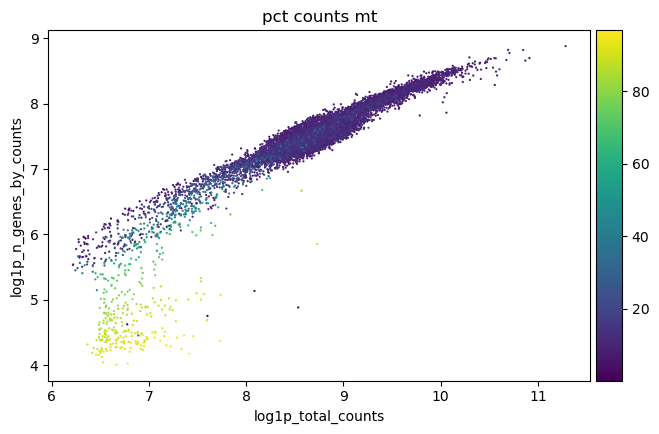

In [21]:
sc.pl.scatter(adata, x='log1p_total_counts', y='log1p_n_genes_by_counts', color='pct_counts_mt')

In [22]:
adata.obs['bad_quality'] = (
    (adata.obs['total_counts'] < 2500) | 
    (adata.obs['total_counts'] > 30000 ) |
    (adata.obs['n_genes_by_counts'] < 1000) |
    (adata.obs['n_genes_by_counts'] > 5500) |
    (adata.obs['pct_counts_mt'] > 20) |
    (adata.obs['predicted_doublets'])
)
adata.obs['bad_quality'].value_counts()

bad_quality
False    10000
True      1769
Name: count, dtype: int64

In [23]:
adata.obs

,doublet_scores,predicted_doublets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,bad_quality
AAACCCAAGCGCCCAT-1,0.052632,False,1087,6.992096,2204.0,7.698483,34.437387,44.782214,55.716878,73.366606,52.0,3.970292,2.359347,True
AAACCCAAGGTTCCGC-1,0.072727,False,4200,8.343078,20090.0,9.908028,30.751618,43.753111,55.739174,67.819811,1324.0,7.189168,6.590343,False
AAACCCACAGAGTTGG-1,0.040688,False,1836,7.515889,5884.0,8.680162,42.641061,52.923182,62.542488,75.254929,633.0,6.452049,10.757988,False
AAACCCACAGGTATGG-1,0.010830,False,2216,7.703910,5530.0,8.618124,32.839060,41.681736,51.175407,65.280289,434.0,6.075346,7.848101,False
AAACCCACATAGTCAC-1,0.029502,False,1615,7.387709,5106.0,8.538367,41.676459,56.423815,65.648257,78.162946,553.0,6.317165,10.830396,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTCATGT-1,0.135196,False,1331,7.194437,3937.0,8.278428,46.405893,55.956312,65.278131,78.892558,783.0,6.664409,19.888241,False
TTTGTTGGTTTGAACC-1,0.023124,False,1401,7.245655,4245.0,8.353733,43.910483,58.186101,67.255595,78.775029,375.0,5.929589,8.833922,False
TTTGTTGTCCAAGCCG-1,0.118367,False,1668,7.419980,5602.0,8.631058,45.430203,59.371653,67.832917,79.150303,524.0,6.263398,9.353803,False
TTTGTTGTCTTACTGT-1,0.043684,False,1745,7.465083,6757.0,8.818482,48.068670,63.830102,71.496226,81.352671,520.0,6.255750,7.695724,False


In [24]:
adata = adata[(~adata.obs['bad_quality'])].copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 10000 × 33538
    obs: 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'bad_quality'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [26]:
sc.pp.filter_genes(adata, min_cells=3)

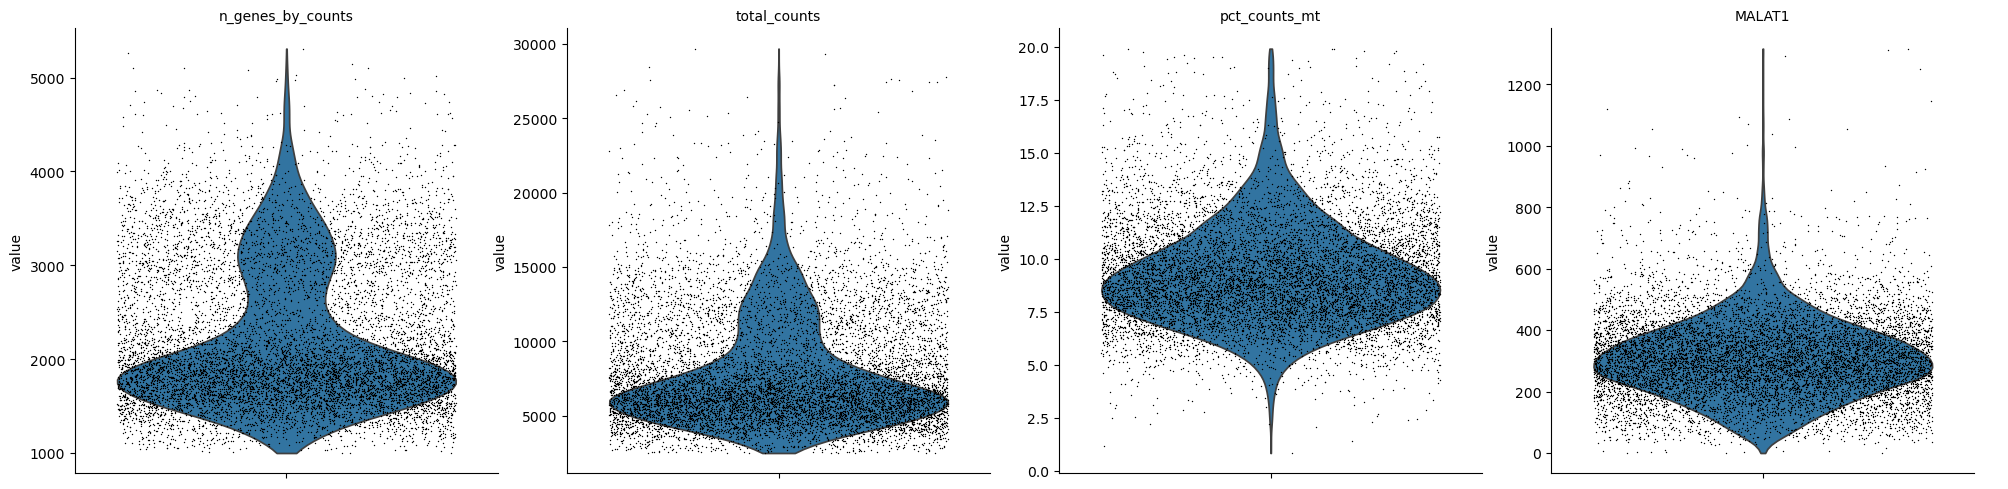

In [27]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "MALAT1"],
    jitter=0.4,
    multi_panel=True
)

In [28]:
adata.obs.predicted_doublets.value_counts()

predicted_doublets
False    10000
Name: count, dtype: int64

In [29]:
adata.obs

,doublet_scores,predicted_doublets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,bad_quality
AAACCCAAGGTTCCGC-1,0.072727,False,4200,8.343078,20090.0,9.908028,30.751618,43.753111,55.739174,67.819811,1324.0,7.189168,6.590343,False
AAACCCACAGAGTTGG-1,0.040688,False,1836,7.515889,5884.0,8.680162,42.641061,52.923182,62.542488,75.254929,633.0,6.452049,10.757988,False
AAACCCACAGGTATGG-1,0.010830,False,2216,7.703910,5530.0,8.618124,32.839060,41.681736,51.175407,65.280289,434.0,6.075346,7.848101,False
AAACCCACATAGTCAC-1,0.029502,False,1615,7.387709,5106.0,8.538367,41.676459,56.423815,65.648257,78.162946,553.0,6.317165,10.830396,False
AAACCCACATCCAATG-1,0.079872,False,1800,7.496097,4572.0,8.427925,35.345582,46.062992,55.993001,70.822397,411.0,6.021023,8.989501,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGCGTCGT-1,0.061849,False,1336,7.198184,5115.0,8.540128,51.163245,67.565982,74.975562,83.655914,365.0,5.902633,7.135875,False
TTTGTTGGTGTCATGT-1,0.135196,False,1331,7.194437,3937.0,8.278428,46.405893,55.956312,65.278131,78.892558,783.0,6.664409,19.888241,False
TTTGTTGGTTTGAACC-1,0.023124,False,1401,7.245655,4245.0,8.353733,43.910483,58.186101,67.255595,78.775029,375.0,5.929589,8.833922,False
TTTGTTGTCCAAGCCG-1,0.118367,False,1668,7.419980,5602.0,8.631058,45.430203,59.371653,67.832917,79.150303,524.0,6.263398,9.353803,False


In [30]:
adata.obs.n_genes_by_counts.describe()

count    10000.000000
mean      2202.207200
std        755.028562
min       1000.000000
25%       1654.000000
50%       1948.000000
75%       2703.000000
max       5308.000000
Name: n_genes_by_counts, dtype: float64

In [31]:
adata.obs.total_counts.describe()

count    10000.000000
mean      7888.499023
std       3787.688721
min       2501.000000
25%       5320.750000
50%       6721.000000
75%       9548.250000
max      29675.000000
Name: total_counts, dtype: float64

### Normalization and multivariate analysis

In [32]:
# Total-count normalization (library-size correct)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [33]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

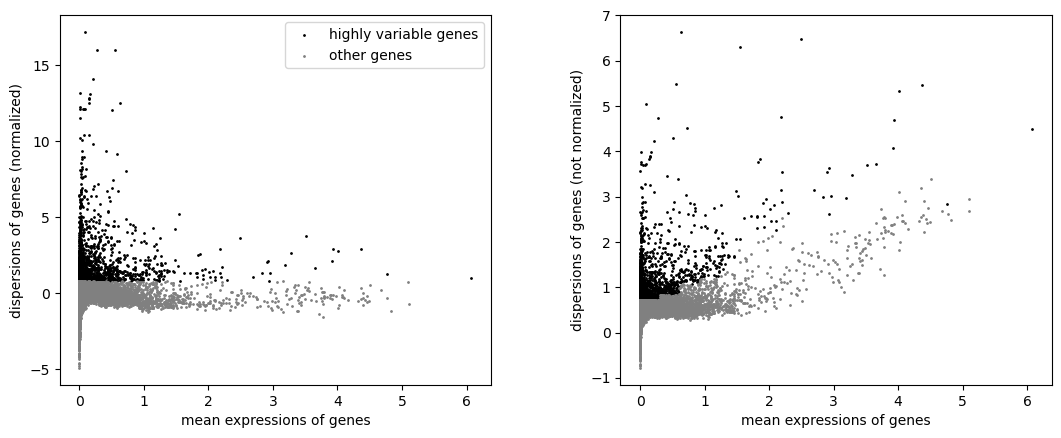

In [34]:
sc.pl.highly_variable_genes(adata)

In [35]:
sc.tl.pca(adata)

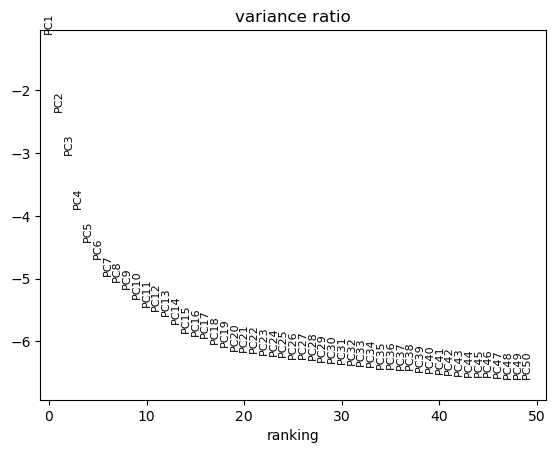

In [36]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [37]:
adata.obsm['X_pca'].shape

(10000, 50)

In [38]:
sc.pp.neighbors(adata)

In [39]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=1)

In [40]:
adata.obs['leiden']

AAACCCAAGGTTCCGC-1     0
AAACCCACAGAGTTGG-1     1
AAACCCACAGGTATGG-1     3
AAACCCACATAGTCAC-1     4
AAACCCACATCCAATG-1     3
                      ..
TTTGTTGGTGCGTCGT-1     7
TTTGTTGGTGTCATGT-1     2
TTTGTTGGTTTGAACC-1    14
TTTGTTGTCCAAGCCG-1     5
TTTGTTGTCTTACTGT-1     5
Name: leiden, Length: 10000, dtype: category
Categories (20, object): ['0', '1', '2', '3', ..., '16', '17', '18', '19']

In [41]:
adata.obs['leiden'].value_counts()

leiden
5     1615
1     1195
7     1162
2     1086
8      776
14     758
11     574
3      563
4      552
15     387
10     344
16     339
12     287
0      125
6      100
13      72
17      22
9       17
18      14
19      12
Name: count, dtype: int64

In [42]:
sc.tl.umap(adata)

In [43]:
# sc.tl.tsne(adata)

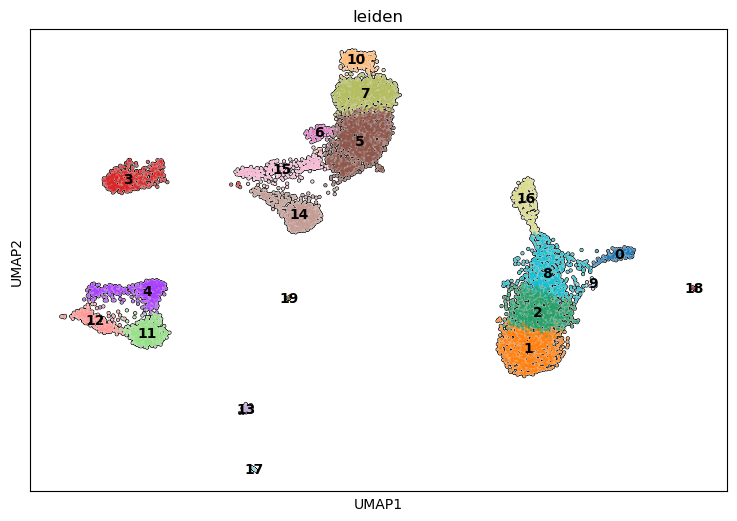

In [44]:
plt.rcParams["figure.figsize"] = (9, 6)
sc.pl.umap(
    adata,
    color="leiden",
    legend_loc='on data',
    add_outline=True,
    frameon=True
)

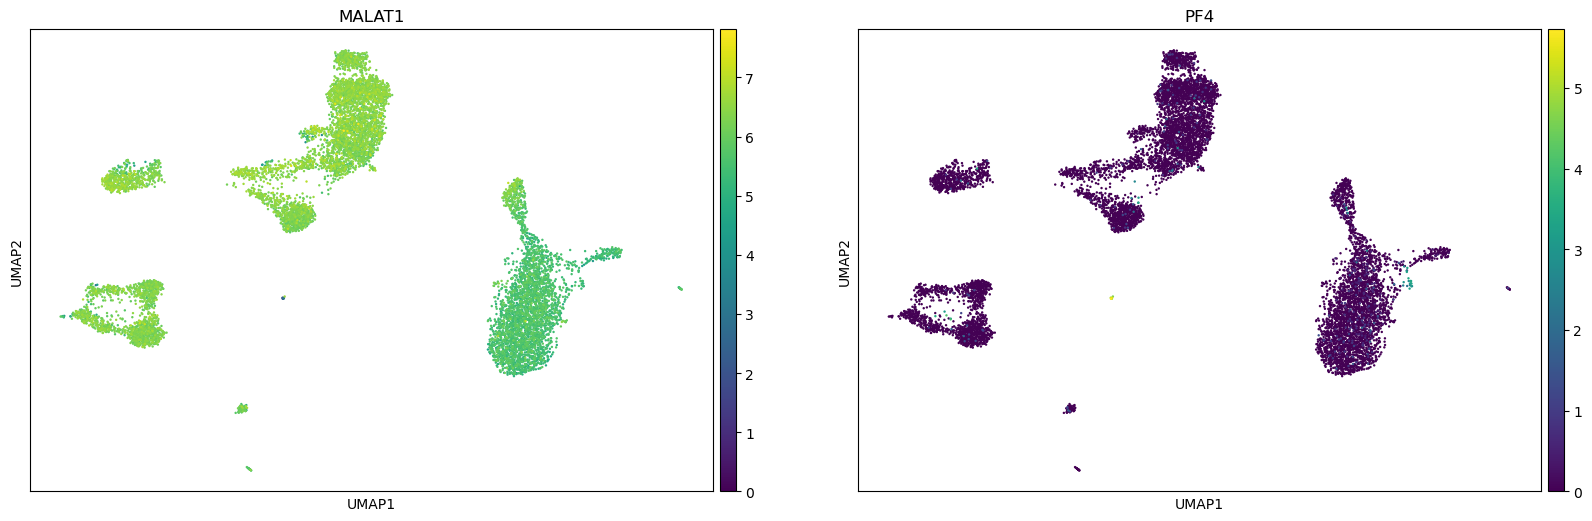

In [45]:
sc.pl.umap(
    adata,
    color=["MALAT1", "PF4"]
)

In [46]:
adata.obs

,doublet_scores,predicted_doublets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,bad_quality,leiden
AAACCCAAGGTTCCGC-1,0.072727,False,4200,8.343078,20090.0,9.908028,30.751618,43.753111,55.739174,67.819811,1324.0,7.189168,6.590343,False,0
AAACCCACAGAGTTGG-1,0.040688,False,1836,7.515889,5884.0,8.680162,42.641061,52.923182,62.542488,75.254929,633.0,6.452049,10.757988,False,1
AAACCCACAGGTATGG-1,0.010830,False,2216,7.703910,5530.0,8.618124,32.839060,41.681736,51.175407,65.280289,434.0,6.075346,7.848101,False,3
AAACCCACATAGTCAC-1,0.029502,False,1615,7.387709,5106.0,8.538367,41.676459,56.423815,65.648257,78.162946,553.0,6.317165,10.830396,False,4
AAACCCACATCCAATG-1,0.079872,False,1800,7.496097,4572.0,8.427925,35.345582,46.062992,55.993001,70.822397,411.0,6.021023,8.989501,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGCGTCGT-1,0.061849,False,1336,7.198184,5115.0,8.540128,51.163245,67.565982,74.975562,83.655914,365.0,5.902633,7.135875,False,7
TTTGTTGGTGTCATGT-1,0.135196,False,1331,7.194437,3937.0,8.278428,46.405893,55.956312,65.278131,78.892558,783.0,6.664409,19.888241,False,2
TTTGTTGGTTTGAACC-1,0.023124,False,1401,7.245655,4245.0,8.353733,43.910483,58.186101,67.255595,78.775029,375.0,5.929589,8.833922,False,14
TTTGTTGTCCAAGCCG-1,0.118367,False,1668,7.419980,5602.0,8.631058,45.430203,59.371653,67.832917,79.150303,524.0,6.263398,9.353803,False,5


## Automatic annotation

In [216]:
# Predict cell types using CellTypist
celltypist_model = celltypist.models.download_models()

📂 Storing models in /home/tomas/.celltypist/data/models
⏩ Skipping [1/54]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/54]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/54]: Adult_COVID19_PBMC.pkl (file exists)
⏩ Skipping [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [5/54]: Adult_Human_MTG.pkl (file exists)
⏩ Skipping [6/54]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [7/54]: Adult_Human_PrefrontalCortex.pkl (file exists)
⏩ Skipping [8/54]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [9/54]: Adult_Human_Vascular.pkl (file exists)
⏩ Skipping [10/54]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [11/54]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [12/54]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [13/54]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [14/54]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [15/54]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [16/54]: COVID19_Immune_Lands

In [217]:
celltypist.models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Human_Vascular.pkl,vascular populations combined from multiple ad...
9,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...


In [51]:
predictions = celltypist.annotate(
    adata, 
    model='Healthy_COVID19_PBMC.pkl',
    majority_voting=True,
    over_clustering='leiden'
)

🔬 Input data has 10000 cells and 19951 genes
🔗 Matching reference genes in the model
🧬 3376 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [52]:
adata = predictions.to_adata()

In [58]:
adata

AnnData object with n_obs × n_vars = 10000 × 19951
    obs: 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'bad_quality', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'majority_voting_colors', 'predicted_labels_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

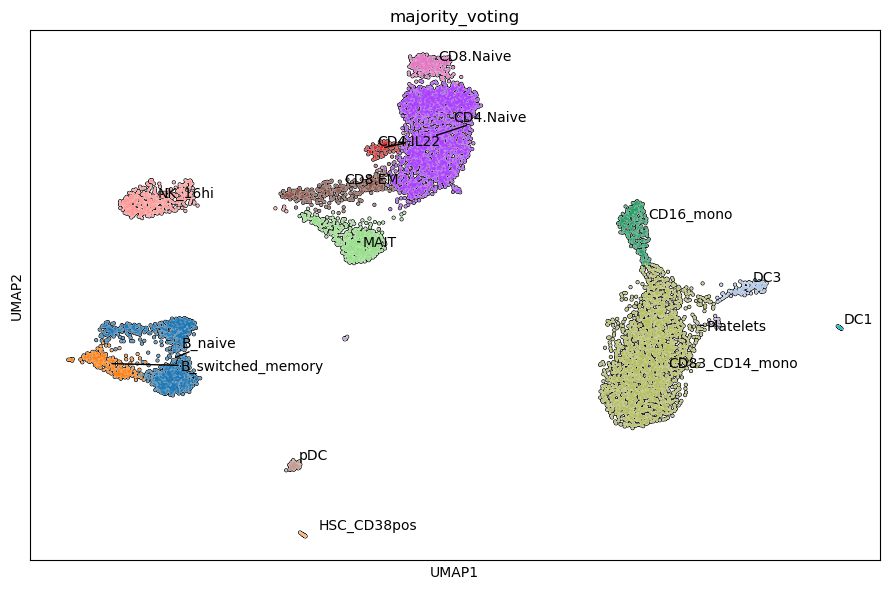

In [57]:
# Ref.: https://github.com/scverse/scanpy/issues/1513
def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

ax = sc.pl.umap(
    adata, 
    color="majority_voting", 
    show=False, 
    legend_loc=None, 
    frameon=True, 
    add_outline=True
)
gen_mpl_labels(
    adata,
    "majority_voting",
    exclude=("None",),  # This was before we had the `nan` behaviour
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize=10),
    
)
fig = ax.get_figure()
fig.tight_layout()
plt.show()

<Axes: title={'center': 'conf_score'}, xlabel='UMAP1', ylabel='UMAP2'>

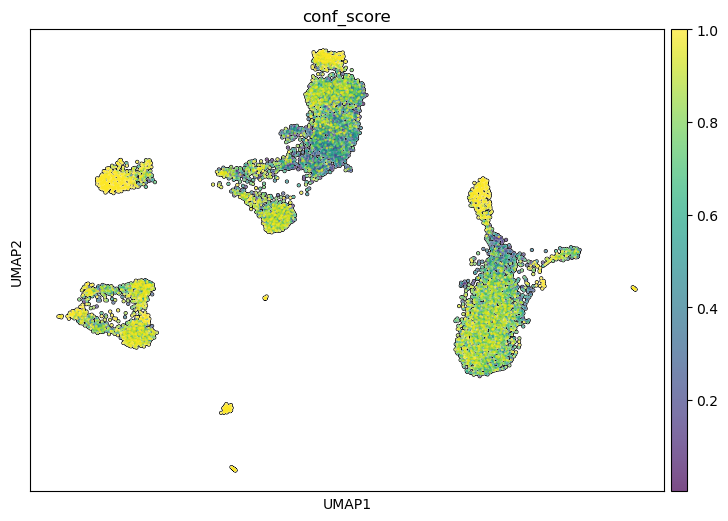

In [232]:
sc.pl.umap(
    adata, 
    color=['conf_score'], 
    legend_loc='on data', 
    add_outline=True, 
    show=False
)

In [ ]:
adata.obs['cluster_dummy'] = adata.obs['predicted_labels'] == 'Platelets'

In [ ]:
sc.pl.umap(adata, color=['cluster_dummy'], legend_loc='right margin')

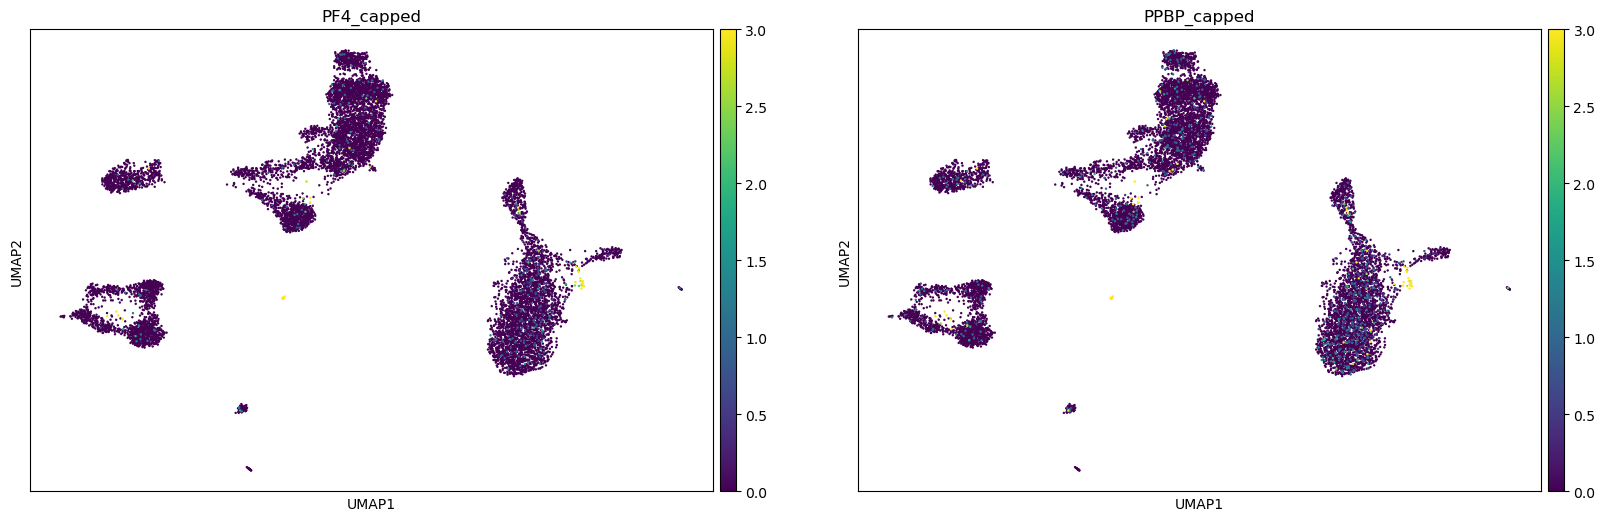

In [62]:
max_cutoff = 3
gene = 'PF4' 
adata.obs[f'{gene}_capped'] = np.minimum(adata[:, gene].X.toarray().flatten(), max_cutoff)
gene2 = 'PPBP'
adata.obs[f'{gene2}_capped'] = np.minimum(adata[:, gene2].X.toarray().flatten(), max_cutoff)

sc.pl.umap(adata, color=[f'{gene}_capped', f'{gene2}_capped'], cmap='viridis')

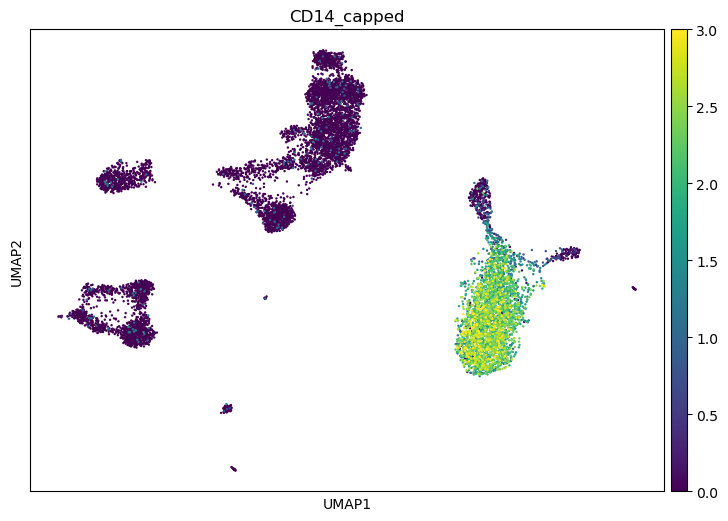

In [64]:
gene = 'CD14'
adata.obs[f'{gene}_capped'] = np.minimum(adata[:, gene].X.toarray().flatten(), max_cutoff)
sc.pl.umap(adata, color=[f'{gene}_capped'], cmap='viridis')

In [ ]:
max_cutoff = 3
gene = 'PPBP'  # Replace with your gene of interest
adata.obs[f'{gene}_capped'] = np.minimum(adata[:, gene].X.toarray().flatten(), max_cutoff)

# Plot the UMAP with the capped expression values
sc.pl.umap(adata, color=f'{gene}_capped', cmap='viridis')

In [ ]:
sc.pl.umap(adata, color=['CD4', 'CD8A'], legend_loc='right margin'), 

In [ ]:
max_cutoff = 1
gene = 'CD4'  # Replace with your gene of interest
adata.obs[f'{gene}_capped'] = np.minimum(adata[:, gene].X.toarray().flatten(), max_cutoff)

# Plot the UMAP with the capped expression values
sc.pl.umap(adata, color=f'{gene}_capped', cmap='viridis')

In [ ]:
max_cutoff = 2
gene = 'CD8A'  # Replace with your gene of interest
adata.obs[f'{gene}_capped'] = np.minimum(adata[:, gene].X.toarray().flatten(), max_cutoff)

# Plot the UMAP with the capped expression values
sc.pl.umap(adata, color=f'{gene}_capped', cmap='viridis')